Step 1: Collect and Explore Data 
1.1. Download dataset from kaggle:https://www.kaggle.com/datasets/uciml/iris?resource=download
1.2. Load the dataset using Pandas:

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import re

In [2]:
# Import dataset from CSV
data = pd.read_csv('Iris.csv')
data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


1.3. Explore the dataset by checking its structure

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    int64  
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB


Step 2: Data Reprocessing

2.1. Handle categorical variables e.g., 'Species':

In [4]:
# Rename the values in the 'species' column
data['Species'] = data['Species'].replace({
    'Iris-setosa': 1,
    'Iris-versicolor': 2,
    'Iris-virginica': 3
})

data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,1
1,2,4.9,3.0,1.4,0.2,1
2,3,4.7,3.2,1.3,0.2,1
3,4,4.6,3.1,1.5,0.2,1
4,5,5.0,3.6,1.4,0.2,1


In [5]:
# Save the cleaned DataFrame to a new CSV file
data.to_csv('cleaned_Iris_data.csv', index=False)

2.3. Feature scaling

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.drop('Species', axis=1)), columns=data.columns[:-1])
data_scaled.head(5)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,-1.720542,-0.900681,1.032057,-1.341272,-1.312977
1,-1.697448,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.674353,-1.385353,0.337848,-1.398138,-1.312977
3,-1.651258,-1.506521,0.106445,-1.284407,-1.312977
4,-1.628164,-1.021849,1.263460,-1.341272,-1.312977


In [7]:
# Save the scaled DataFrame to a new CSV file
data_scaled.to_csv('data_scaled.csv', index=False)

Step 3: Split Data into Training and Testing Sets

In [8]:
#Split Data into Training and Testing Sets
from sklearn.model_selection import train_test_split

# Separate features and target
X = data_scaled
y = data['Species']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Training Set Shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nTesting Set Shapes:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


Training Set Shapes:
X_train shape: (120, 5)
y_train shape: (120,)

Testing Set Shapes:
X_test shape: (30, 5)
y_test shape: (30,)


Step 4: Train and Evaluate Models

4.1. Import classifiers and train models:

In [9]:
#Train and Evaluate Models
#Import classifiers and train models:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machines": SVC(),
    "Decision Trees": DecisionTreeClassifier(),
    "Random Forests": RandomForestClassifier()
}

# Reshape X_train to a 2D array
#X_train = X_train.reshape(1, -1)

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name}: {model.score(X_test, y_test)}")

Logistic Regression: 1.0
K-Nearest Neighbors: 1.0
Support Vector Machines: 1.0
Decision Trees: 1.0
Random Forests: 1.0


Step 5: Model Tuning

5.1. Hyperparameter tuning using GridSearchCV (example for Random Forests):

In [10]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print(f"Best model: {best_model}")
print(f"Best score: {grid.best_score_}")

Best model: RandomForestClassifier(n_estimators=200)
Best score: 1.0
CPU times: total: 2.02 s
Wall time: 38.1 s


5.2 feature_selection using RFECV

In [11]:
%%time
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score

# Instantiate the best model from Step 4 (e.g., Random Forests)
best_model = RandomForestClassifier(n_estimators=200)

# Create the RFECV object and fit it to the training data
selector = RFECV(best_model, step=1, cv=5, scoring='accuracy')
selector.fit(X_train, y_train)

# Get the selected features and their ranks
selected_features = X_train.columns[selector.support_]
feature_ranks = selector.ranking_

print(f"Selected features: {selected_features}")
print(f"Feature ranks: {feature_ranks}")

Selected features: Index(['Id', 'PetalLengthCm'], dtype='object')
Feature ranks: [1 3 4 1 2]
CPU times: total: 6.86 s
Wall time: 8.56 s


5.3 Remove target variable from the list of selected features if it's present and export in csv

In [12]:
# Convert selected_features to a list
selected_features_list = selected_features.tolist()

# Remove target variable from the list of selected features if it's present
#None

# Create new dataframes with only the selected features
X_train_selected = X_train[selected_features_list]
X_test_selected = X_test[selected_features_list]

# Save X_train_selected as a CSV file
pd.DataFrame(X_train_selected).to_csv('X_train_selected.csv', index=False)

5.4 Train the model with the list of selected features

In [13]:
best_model=best_model.fit(X_train_selected, y_train)

# Make predictions on the test set
y_pred = best_model.predict(X_test_selected)

# Evaluate the model using accuracy_score
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy with selected features: {test_accuracy}")

Test accuracy with selected features: 1.0


5.5 Model evaluation

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions on the test set
y_pred = best_model.predict(X_test_selected)

# Calculate evaluation scores
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # Use macro, micro, or weighted
recall = recall_score(y_test, y_pred, average='macro')        # Use macro, micro, or weighted
f1 = f1_score(y_test, y_pred, average='macro')                # Use macro, micro, or weighted

# For roc_auc_score, if it's multiclass, you need to use the `multi_class` parameter
if len(set(y_test)) > 2:
    auc_roc = roc_auc_score(y_test, best_model.predict_proba(X_test_selected), multi_class='ovr')  # or 'ovo'
else:
    auc_roc = roc_auc_score(y_test, y_pred)

# Print evaluation scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
AUC-ROC: 1.0000


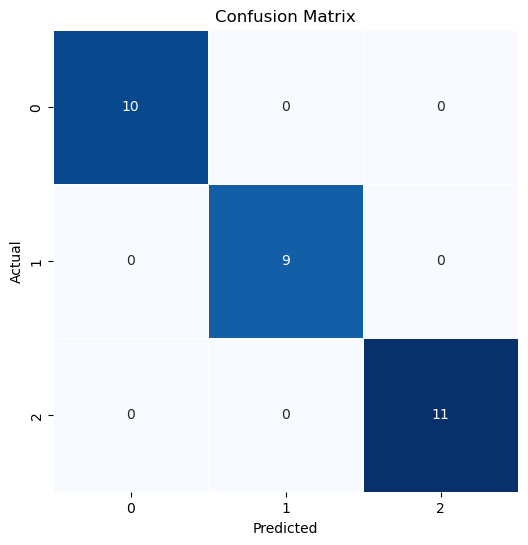

In [15]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


# Save the confusion matrix as an image

plt.savefig('confusion_matrix.png')

5.6 To save the best features list as json for future use

In [16]:
import json
selected_features_list = selected_features.tolist()

with open("selected_features.json", "w") as f:
    json.dump(selected_features_list, f)

5.7 To save the best model using joblib

In [17]:
import joblib

# Save the best model to a file
joblib.dump(best_model, "best_model1.pkl")

['best_model1.pkl']

Step 6: Create Streamlit Web App

In [19]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import joblib

# Load the trained model and scaler
model = joblib.load("best_model1.pkl")

# Define the app title and layout
st.title("Iris Flower Species App")

# Define input fields for features
id = st.number_input("Id", min_value=0, max_value=100, value=60, step=1)
sepal_length_cm = st.number_input("Sepal Length in CM", min_value=0.0, max_value=10.0, value=5.0, step=0.1)
sepal_width_cm = st.number_input("Sepal Width in CM", min_value=0.0, max_value=10.0, value=5.0, step=0.1)
petal_length_cm = st.number_input("Petal Length in CM", min_value=0.0, max_value=10.0, value=5.0, step=0.1)
petal_width_cm = st.number_input("Petal Width in CM", min_value=0.0, max_value=10.0, value=5.0, step=0.1)

# Create a button for making predictions
if st.button("Predict"):
    # Process input values
    input_data = pd.DataFrame(
        {
            "Id": [id],
            "SepalLengthCm": [sepal_length_cm],
            "SepalWidthCm": [sepal_width_cm],
            "PetalLengthCm": [petal_length_cm],
            "PetalWidthCm": [petal_width_cm]
        }
    )

    # Scale input data using the scaler used during training
    input_data_scaled = scaler.transform(input_data)

    # Make a prediction using the trained model
    prediction = model.predict(input_data_scaled)

    # Display the prediction
    if prediction[0] == 1:
        st.success("Unhealthy Flower.")
    else:
        st.success("Healthy Flower.")


2024-06-25 17:59:30.069 
  command:

    streamlit run c:\Users\HomePC\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
